[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/garyuppal/blog-code/blob/main/double_descent_overview/example.ipynb?fresh=true)

This code is to accompany the blog post...


In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Installing dependencies from requirements.txt...")
    !pip install -r https://raw.githubusercontent.com/garyuppal/blog-code/refs/heads/main/double_descent_overview/requirements.txt
else:
    print("Running locally...")

Running locally...


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap, Normalize, TwoSlopeNorm
import matplotlib.pyplot as plt


In [3]:
# change font to arial
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
# set random seed for reproducibility
np.random.seed(42)

In [5]:
# Create output directory if it doesn't exist
outpath = Path("output")
outpath.mkdir(parents=True, exist_ok=True)

In [6]:
# Function to generate data
def data_func(x):
    return 5*x + 10*np.cos(15.0*x)

In [7]:
n_data = 40

x = np.sort(np.random.rand(n_data)) #np.linspace(0,1,n_data)
eps = np.random.normal(loc=0,scale=1,size=x.shape)
y = data_func(x)
data = y + eps

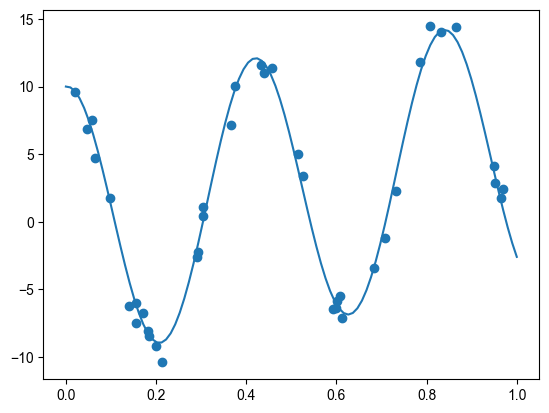

In [8]:
fig, ax = plt.subplots()
xplot = np.linspace(0, 1, 100)
yplot = data_func(xplot)
ax.plot(xplot,yplot)
ax.scatter(x,data)

## split data into test and train sets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, data, test_size=0.2, random_state=10)

/tmp/ipykernel_165535/537474392.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_165535/537474392.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)


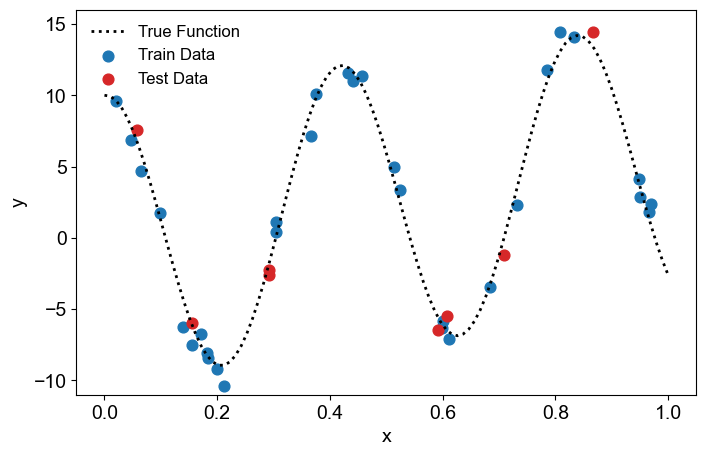

In [10]:
fontsize = 14
lgd_fontsize = 12
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(xplot,yplot,':', label='True Function', color='black', linewidth=2)
ax.scatter(x_train, y_train, s=60, color='tab:blue', label='Train Data')
ax.scatter(x_test, y_test, s=60, color='tab:red', label='Test Data')
ax.set_xlabel('x', fontsize=fontsize)
ax.set_ylabel('y', fontsize=fontsize)
ax.set_ylim(-11, 16)
ax.legend(fontsize=lgd_fontsize, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
plt.savefig(outpath / "data_plot.svg", bbox_inches='tight')

<!-- # Fit with Legendre polynomials -->

# Fit data with Legendre polynomial basis

In [11]:
from numpy.polynomial.legendre import Legendre

### to do? can try just polynomial regression too?

In [12]:
def fit_legendre(x,y,P, ridge_lambda=None):
    # Normalize x to [-1, 1] because Legendre polynomials are defined on that interval
    x = np.asarray(x)
    x_min, x_max = x.min(), x.max()
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1

    # Build the design matrix with Legendre basis
    X_design = np.vstack([Legendre.basis(p)(x_scaled) for p in range(P + 1)]).T

    n = len(x)
    if ridge_lambda is not None:
            A = X_design.T @ X_design + ridge_lambda * np.eye(P+1)
            b = X_design.T @ y
            beta = np.linalg.solve(A, b) 
    else:
        if P < n:
            # beta = beta_under
            beta = np.linalg.solve(X_design.T @ X_design, X_design.T @ y)
            # beta_over = None
        else:
            # beta = beta_over
            # beta_over = X^T (XX^T)^-1 y
            z = np.linalg.solve(X_design @ X_design.T, y)
            beta = X_design.T @ z
            # beta_under = None

    return beta, X_design, (x_min, x_max)

In [13]:
def plot_fit(ax, x_train, y_train, x_test, y_test, beta, xmin, xmax):
    P = len(beta)
    # Predict on new data
    x_plot = np.sort(np.concatenate([np.linspace(xmin, xmax, 2000), x_train, x_test]))
    x_plot_scaled = 2 * (x_plot - xmin) / (xmax - xmin) - 1
    X_plot_design = np.vstack([Legendre.basis(p)(x_plot_scaled) for p in range(P)]).T
    y_pred = X_plot_design @ beta

    ax.scatter(x_train, y_train, label="Train data", s=60, color='tab:blue')
    ax.scatter(x_test, y_test, label="Test data", s=60, color='tab:red')
    ax.plot(x_plot, y_pred, color='black', label=f"Legendre Fit (P={P})")
    # ax.plot(x_plot, y_pred_over, color='orange', label=f"Legendre Fit (green) (P={P})")
    ax.legend()
    return ax

In [14]:
# P = 40
# beta, X_design, (xmin, xmax) = fit_legendre(x_train, y_train, P, ridge_lambda=None)

# print(xmin, xmax)

# # Predict on new data
# x_plot = np.sort(np.concatenate([np.linspace(xmin, xmax, 2000), x_train, x_test]))
# x_plot_scaled = 2 * (x_plot - xmin) / (xmax - xmin) - 1
# X_plot_design = np.vstack([Legendre.basis(p)(x_plot_scaled) for p in range(P + 1)]).T
# y_pred = X_plot_design @ beta
# # _under = X_plot_design @ beta_under
# # y_pred_over = X_plot_design @ beta_over
# # 
# # Plot
# fig, ax = plt.subplots()
# ax.scatter(x_train, y_train, label="Data", s=20, color='tab:blue')
# ax.scatter(x_test, y_test, label="Data", s=20, color='tab:red')
# ax.plot(x_plot, y_pred, color='red', label=f"Legendre Fit (P={P})")
# # ax.plot(x_plot, y_pred_over, color='orange', label=f"Legendre Fit (green) (P={P})")
# ax.legend()
# ax.set_title("Legendre Polynomial Fit")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.grid(True)
# ax.set_ylim(-15,15)

In [15]:
# P = 100
# beta, X_design, (xmin, xmax) = fit_legendre(x_train, y_train, P, ridge_lambda=None)

# print(xmin, xmax)

# # Predict on new data
# x_plot = np.sort(np.concatenate([np.linspace(xmin, xmax, 2000), x_train, x_test]))
# x_plot_scaled = 2 * (x_plot - xmin) / (xmax - xmin) - 1
# X_plot_design = np.vstack([Legendre.basis(p)(x_plot_scaled) for p in range(P + 1)]).T
# y_pred = X_plot_design @ beta
# # _under = X_plot_design @ beta_under
# # y_pred_over = X_plot_design @ beta_over

# # Plot
# fig, ax = plt.subplots()
# ax.scatter(x_train, y_train, label="Data", s=20, color='tab:blue')
# ax.scatter(x_test, y_test, label="Data", s=20, color='tab:red')
# ax.plot(x_plot, y_pred, color='red', label=f"Legendre Fit (P={P})")
# # ax.plot(x_plot, y_pred_over, color='orange', label=f"Legendre Fit (green) (P={P})")
# ax.legend()
# ax.set_title("Legendre Polynomial Fit")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.grid(True)
# ax.set_ylim(-55,25)

In [16]:
# X_design.shape

## plot errors over model size

In [17]:
# Function to calculate Root Mean Square Error (RMSE)
def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

In [18]:
def get_train_test_errors(xTrain, yTrain, xTest, yTest,P, ridge_lambda=None):
    beta, X_design, (x_min, x_max) = fit_legendre(xTrain,yTrain,P,ridge_lambda=ridge_lambda)

    x_train_scaled = 2*(xTrain - x_min)/(x_max - x_min) - 1
    x_test_scaled = 2*(xTest - x_min)/(x_max - x_min) - 1

    X_design_train = np.vstack([Legendre.basis(p)(x_train_scaled) for p in range(P + 1)]).T
    X_design_test = np.vstack([Legendre.basis(p)(x_test_scaled) for p in range(P + 1)]).T

    y_pred_train = X_design_train @ beta
    y_pred_test = X_design_test @ beta

    err_train = rmse(yTrain, y_pred_train)
    err_test = rmse(yTest, y_pred_test)
    return err_train, err_test, beta, X_design, (x_min, x_max)

In [19]:
def compute_effective_num_params(x_train, x_test, beta, xmin, xmax):
    P = len(beta)

    X_train_design = np.vstack([Legendre.basis(p)(2 * (x_train - xmin) / (xmax - xmin) - 1) for p in range(P)]).T # NxP
    X_test_design = np.vstack([Legendre.basis(p)(2 * (x_test - xmin) / (xmax - xmin) - 1) for p in range(P)]).T # MxP

    n_train = len(x_train)
    n_test = len(x_test)

    if P < n_train:
        # Under-parameterized case
        beta_hat = np.linalg.pinv(X_train_design.T @ X_train_design) @ X_train_design.T # PxN
    else:
        # Over-parameterized case
        beta_hat = X_train_design.T @ np.linalg.pinv(X_train_design @ X_train_design.T) # PxN
    # print(X_train_design.shape, X_test_design.shape, beta_hat.shape)
    S_hat_train = X_train_design @ beta_hat
    S_hat_test = X_test_design @ beta_hat

    # Compute effective number of parameters
    p_eff_train = np.trace(S_hat_train @ S_hat_train.T)
    p_eff_test = np.trace(S_hat_test @ S_hat_test.T) *(n_train / n_test)
    return p_eff_train, p_eff_test

In [20]:
def get_errors_vs_model_size(xTrain, yTrain, xTest, yTest, P_list, ridge_lambda=None):
    train_errors = np.zeros(len(P_list))
    test_errors = np.zeros(len(P_list))
    betas = []
    X_designs = []
    x_mins = []
    x_maxs = []
    pe_trains = []
    pe_tests = []
    # Loop over each polynomial degree in P_list
    for i,p in enumerate(P_list):
        err_train, err_test, beta, X_design, (x_min, x_max) = get_train_test_errors(xTrain, yTrain, xTest, yTest, p, ridge_lambda)
        train_errors[i] = err_train
        test_errors[i] = err_test
        betas.append(beta)
        X_designs.append(X_design)
        x_mins.append(x_min)
        x_maxs.append(x_max)
        pe_train, pe_test = compute_effective_num_params(xTrain, xTest, beta, x_min, x_max)
        pe_trains.append(pe_train)
        pe_tests.append(pe_test)
    return train_errors, test_errors, betas, X_designs, x_mins, x_maxs, pe_trains, pe_tests

In [21]:
P_list = np.arange(1,200,1) # can cahnge to 300 or so for nicer plot
train_errors, test_errors, betas, X_designs, x_mins, x_maxs, pe_trains, pe_tests = get_errors_vs_model_size(x_train, y_train, x_test, y_test, P_list)

In [22]:
len(x_train)

32

/tmp/ipykernel_165535/2730760035.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_165535/2730760035.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)


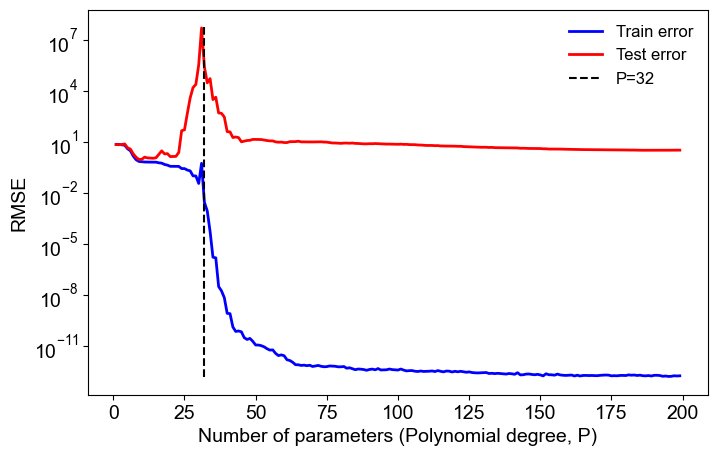

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(P_list, train_errors, color='blue', label='Train error', linewidth=2)
ax.plot(P_list, test_errors, color='red', label='Test error', linewidth=2)
ax.vlines(x=len(x_train), ymin=0.9*np.amin(train_errors), ymax=1.1*np.amax(test_errors), color='black', linestyle='--', label=f'P={len(x_train)}')
ax.set_xlabel('Number of parameters (Polynomial degree, P)', fontsize=fontsize)
ax.set_ylabel('RMSE', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
ax.legend(fontsize=lgd_fontsize, frameon=False)
ax.set_yscale('log')
plt.savefig(outpath / "errors_vs_model_size.svg", bbox_inches='tight')

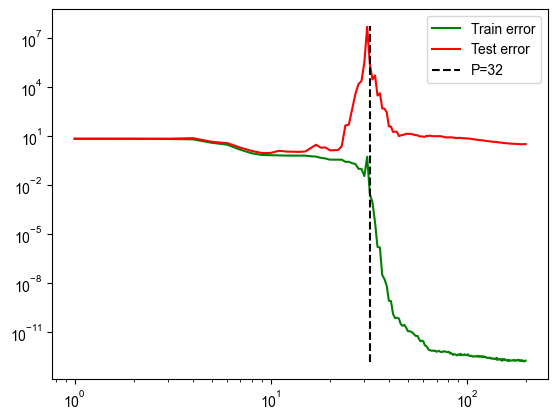

In [24]:
fig, ax = plt.subplots()
ax.plot(P_list, train_errors, color='green', label='Train error')
ax.plot(P_list, test_errors, color='red', label='Test error')
ax.vlines(x=len(x_train), ymin=0.9*np.amin(train_errors), ymax=1.1*np.amax(test_errors), color='black', linestyle='--', label=f'P={len(x_train)}')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

In [25]:
min_idx = np.argmax(test_errors == np.amin(test_errors))

In [26]:
print(np.amin(test_errors))
print(test_errors[min_idx])

0.9518950919735925
0.9518950919735925


## plot some example fits

/tmp/ipykernel_165535/1093581266.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_165535/1093581266.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
/tmp/ipykernel_165535/1093581266.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_165535/1093581266.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
/tmp/ipykernel_165535/1093581266.py:8: UserWarning: set_ticklabels() should only be 

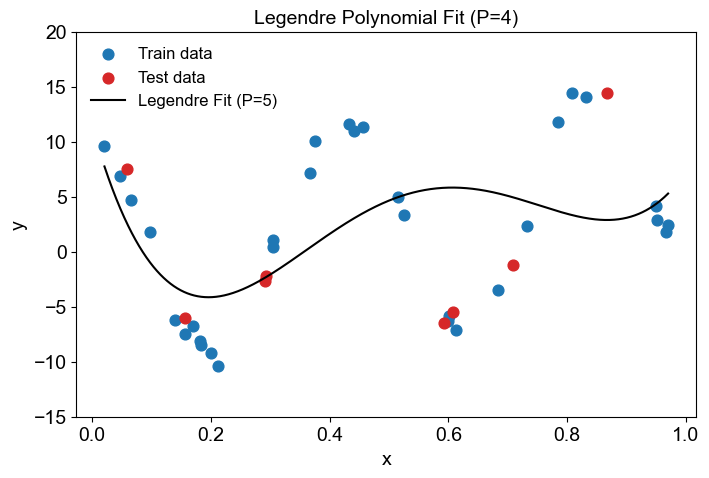

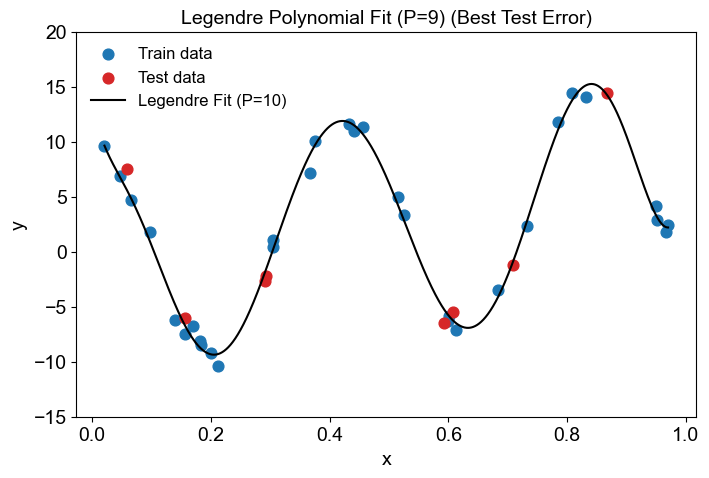

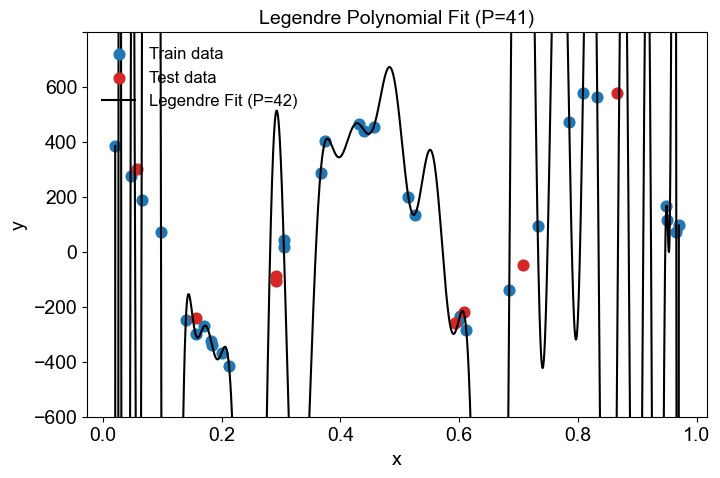

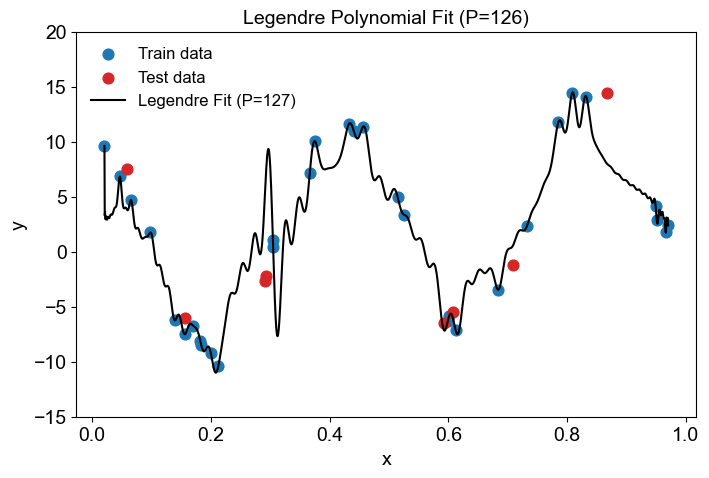

In [33]:
idxs = [3, min_idx, 40, 125]
for idx in idxs:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax=plot_fit(ax, x_train, y_train, x_test, y_test, betas[idx], x_mins[idx], x_maxs[idx])
    ax.legend(fontsize=lgd_fontsize, frameon=False)
    ax.set_xlabel('x', fontsize=fontsize)
    ax.set_ylabel('y', fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
    ax.set_ylim(-15,20)
    if idx == min_idx:
        ax.set_title(f"Legendre Polynomial Fit (P={P_list[idx]}) (Best Test Error)", fontsize=fontsize)
    else:
        ax.set_title(f"Legendre Polynomial Fit (P={P_list[idx]})", fontsize=fontsize)
    plt.savefig(outpath / f"fit_at_{idx}.svg", bbox_inches='tight') 

## plot test error vs effective number of params

In [34]:
class PiecewiseNormalize(Normalize):
    def __init__(self, vmin, vmax, pmax):
        super().__init__(vmin, vmax)
        self.pmax = pmax

    def __call__(self, value, clip=None):
        value = np.clip(value, self.vmin, self.vmax)
        scale = np.where(value <= self.pmax,
                         0.5 * (value - self.vmin) / (self.pmax - self.vmin),
                         0.5 + 0.5 * (value - self.pmax) / (self.vmax - self.pmax))
        return scale

    def inverse(self, value):
        value = np.asarray(value)
        return np.where(value <= 0.5,
                        self.vmin + (value / 0.5) * (self.pmax - self.vmin),
                        self.pmax + ((value - 0.5) / 0.5) * (self.vmax - self.pmax))

In [35]:
# Custom combined colormap
colors1 = plt.get_cmap('Blues_r')(np.linspace(0.3, 1, 128))
colors2 = plt.get_cmap('Reds')(np.linspace(0.3, 1, 128))
combined_colors = np.vstack([colors1, colors2])
combined_cmap = ListedColormap(combined_colors)

# Apply
vmin, vmax = np.amin(P_list), np.amax(P_list)
pmax = len(x_train)  # This is the point where we switch from blue to red

norm = TwoSlopeNorm(vmin=vmin, vcenter=pmax, vmax=vmax)


In [37]:
min_idx

np.int64(8)

/tmp/ipykernel_165535/2500909522.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
/tmp/ipykernel_165535/2500909522.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)


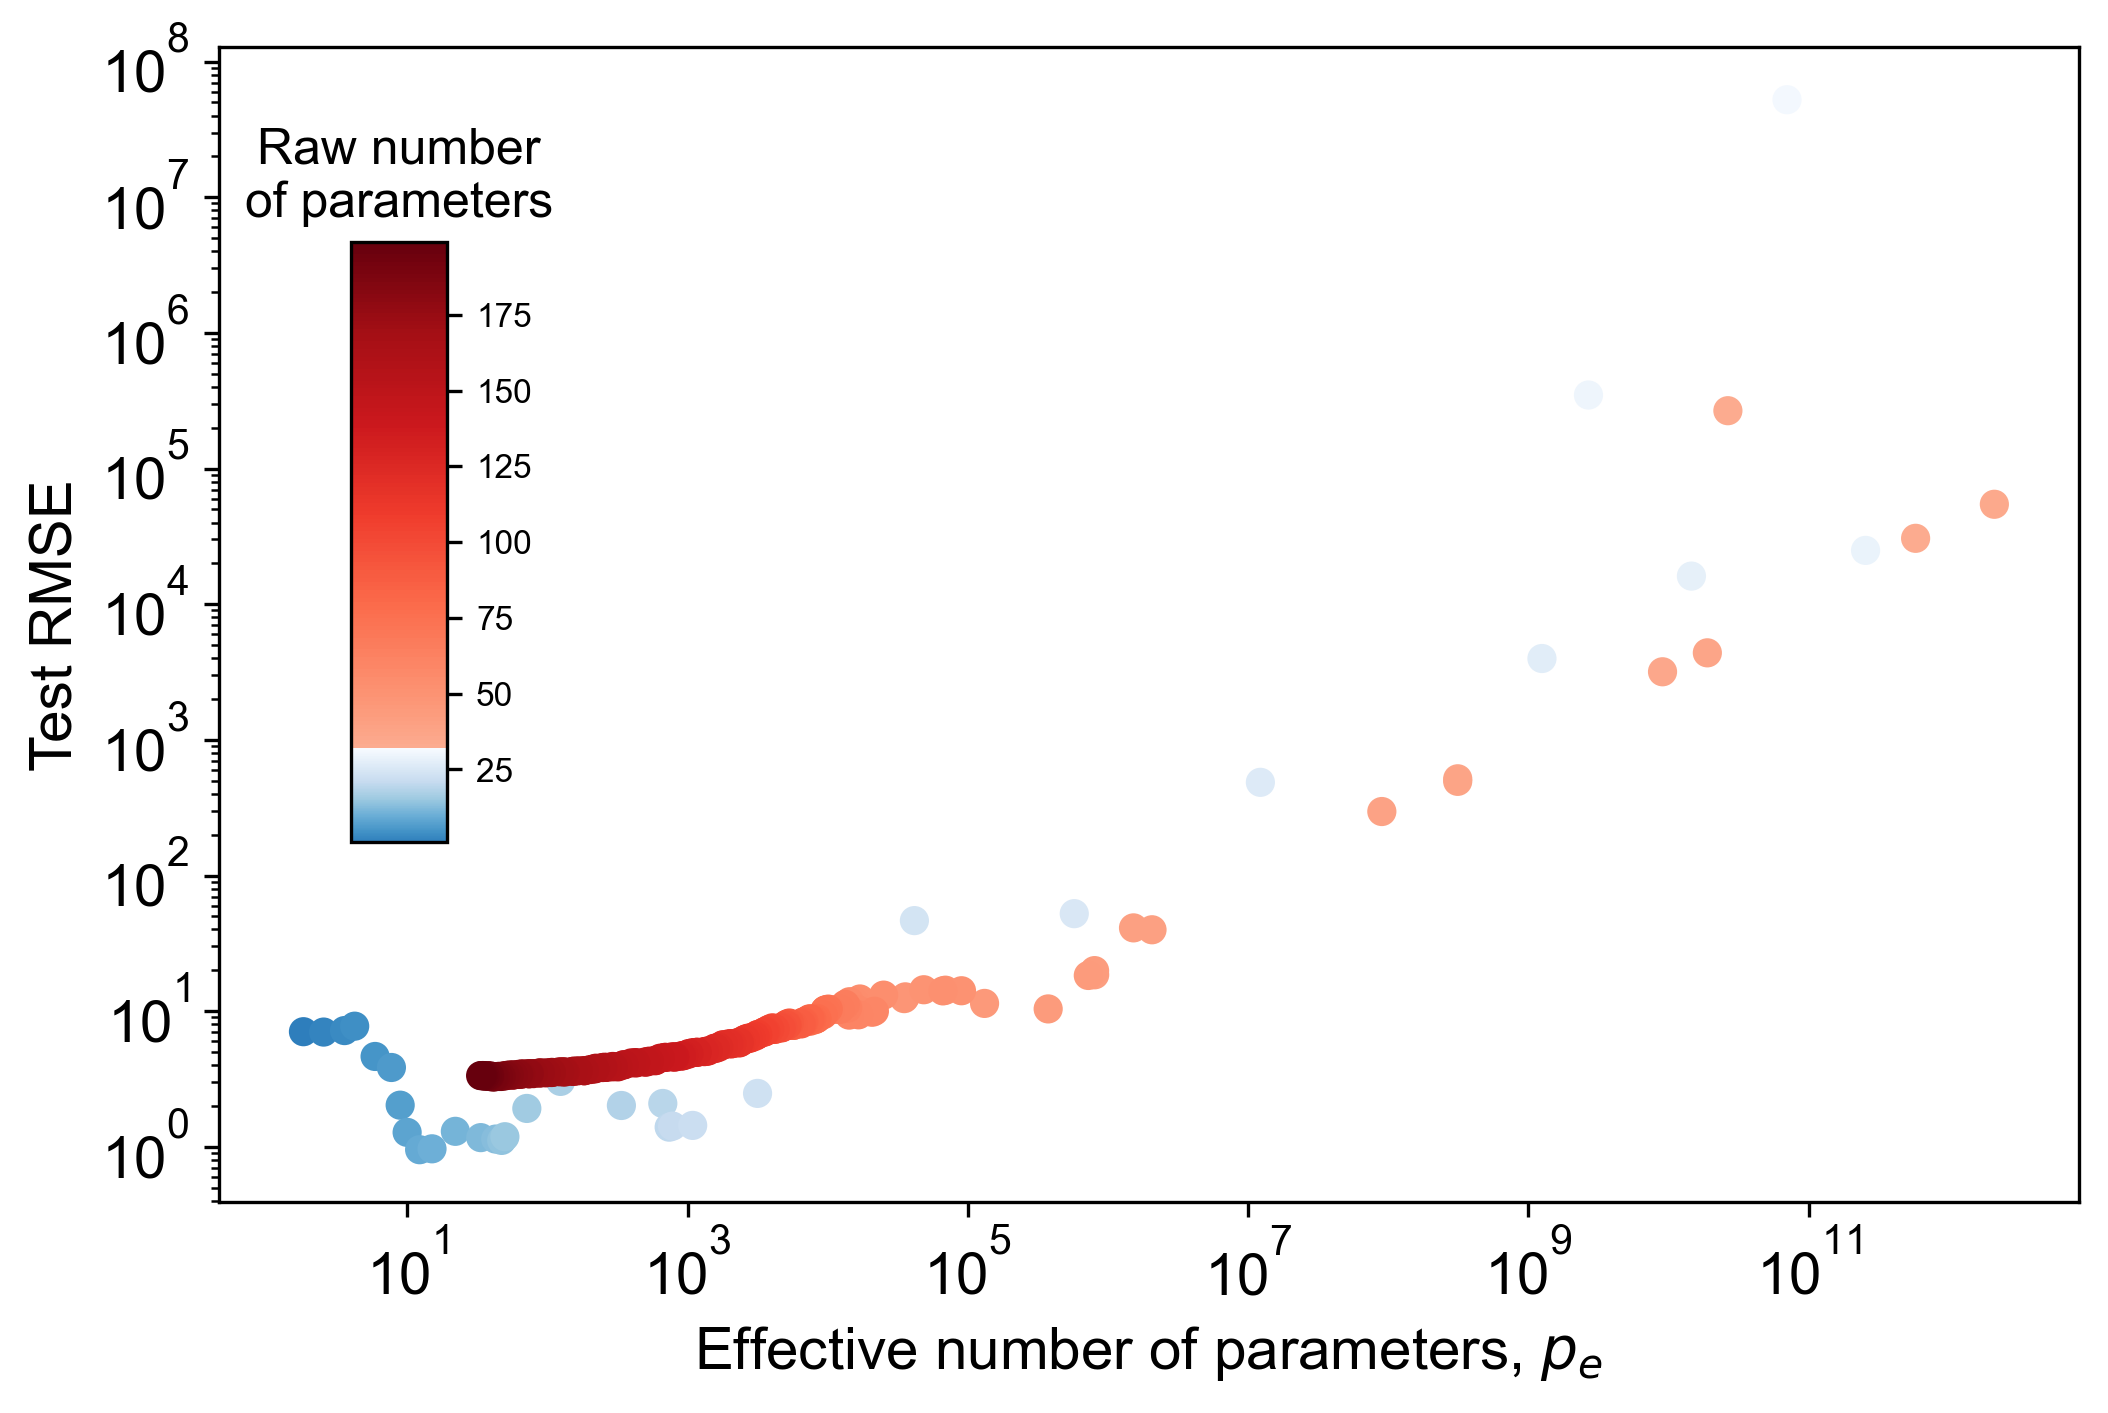

In [45]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
# Scatter plot with color mapping
sc = ax.scatter(pe_tests, test_errors, c=P_list, cmap=combined_cmap, norm=norm)

cax = fig.add_axes([0.18, 0.35, 0.04, 0.4])  # (left, bottom, width, height)
cb = plt.colorbar(sc, cax=cax, norm=norm, ticks=[vmin, pmax, vmax])
cb.ax.tick_params(labelsize=8)
cb.ax.set_yscale('linear')

cb.ax.set_title('Raw number\nof parameters', fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'Effective number of parameters, $p_e$', fontsize=fontsize)
ax.set_ylabel('Test RMSE', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
plt.savefig(outpath / "effective_params_vs_test_rmse.png", dpi=300, bbox_inches='tight')

## looks good!, lets clean things up and finalize everything and finish rough draft!!

would also be interesting to see the actual "fold over", by getting a picture of what p_actual is ?; can we color points by p_actual?

### getting muliple lines, do we want to also look at p_ex as in paper? vs p_PC

In [ ]:
np.argmin(test_errors)

In [ ]:
# test_errors

In [ ]:
np.amin(test_errors), np.amax(test_errors)

In [ ]:
# plot_fit(x_train, y_train, betas[25], X_designs[25], x_mins[25], x_maxs[25])
idx = 41
fig, ax = plot_fit(x_train, y_train, x_test, y_test, betas[idx], x_mins[idx], x_maxs[idx])

In [ ]:
fig, ax = plot_fit(x_train, y_train, x_test, y_test, betas[idx], x_mins[idx], x_maxs[idx])
ax.set_ylim(-15, 15)

## compute effective number of parameters
build this in with above, do at once

In [ ]:
def compute_effective_num_params2(x_train, x_test, beta, xmin, xmax):
    P = len(beta)
    # Normalize inputs to [-1, 1]
    x_train_scaled = 2 * (x_train - xmin) / (xmax - xmin) - 1
    x_test_scaled = 2 * (x_test - xmin) / (xmax - xmin) - 1

    # Build design matrices
    X_train_design = np.vstack([Legendre.basis(p)(x_train_scaled) for p in range(P)]).T  # (N, P)
    X_test_design = np.vstack([Legendre.basis(p)(x_test_scaled) for p in range(P)]).T    # (M, P)

    n_train, n_test = len(x_train), len(x_test)

    # Compute stable pseudo-inverse using SVD
    U, s, VT = np.linalg.svd(X_train_design, full_matrices=False)
    S_inv = np.diag(1.0 / s)
    beta_hat = VT.T @ S_inv @ U.T  # shape (P, N)

    # Smoother matrices
    S_hat_train = X_train_design @ beta_hat  # shape (N, N)
    S_hat_test = X_test_design @ beta_hat    # shape (M, N)

    # Effective number of parameters
    p_eff_train = np.trace(S_hat_train @ S_hat_train.T)
    p_eff_test = np.trace(S_hat_test @ S_hat_test.T) * (n_train / n_test)

    row_norms_squared = np.sum(S_hat_test**2, axis=1)  # shape: (M,)
    p_eff_test = (n_train / n_test) * np.sum(row_norms_squared)
    return p_eff_train, p_eff_test

In [ ]:
print(len(x_train), len(x_test))

In [ ]:
idx = 100
pe_train, pe_test = compute_effective_num_params(x_train, x_test, betas[idx], x_mins[idx], x_maxs[idx])
print(pe_train, pe_test)
print(np.log10(pe_test))

In [ ]:
idx = 101
pe_train, pe_test = compute_effective_num_params(x_train, x_test, betas[idx], x_mins[idx], x_maxs[idx])
print(pe_train, pe_test)

In [ ]:
idx = 30
pe_train, pe_test = compute_effective_num_params(x_train, x_test, betas[idx], x_mins[idx], x_maxs[idx])
print(pe_train, pe_test)

In [ ]:
idx = 60
beta = betas[idx]
xmin = x_mins[idx]
xmax = x_maxs[idx]

P = len(beta)

X_train_design = np.vstack([Legendre.basis(p)(2 * (x_train - xmin) / (xmax - xmin) - 1) for p in range(P)]).T # NxP
X_test_design = np.vstack([Legendre.basis(p)(2 * (x_test - xmin) / (xmax - xmin) - 1) for p in range(P)]).T # MxP

n_train = len(x_train)
n_test = len(x_test)

if P < n_train:
    # Under-parameterized case
    beta_hat = np.linalg.pinv(X_train_design.T @ X_train_design) @ X_train_design.T # PxN
else:
    # Over-parameterized case
    beta_hat = X_train_design.T @ np.linalg.pinv(X_train_design @ X_train_design.T) # PxN
# print(X_train_design.shape, X_test_design.shape, beta_hat.shape)
S_hat_train = X_train_design @ beta_hat
S_hat_test = X_test_design @ beta_hat

# Compute effective number of parameters
p_eff_train = np.trace(S_hat_train @ S_hat_train.T)
p_eff_test = np.trace(S_hat_test @ S_hat_test.T) *(n_train / n_test)

print(p_eff_train, p_eff_test)

In [ ]:
print(np.amin(beta_hat), np.amax(beta_hat))

In [ ]:
print(np.amin(S_hat_train), np.amax(S_hat_train))
print(np.amin(S_hat_test), np.amax(S_hat_test))

In [ ]:
print(S_hat_train.shape, S_hat_test.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.heatmap(S_hat_train)

In [ ]:
sns.heatmap(X_test_design)

In [ ]:
print(np.amin(X_test_design), np.amax(X_test_design))

# TODO: use -1,1 interval and remove rescaling

# old

In [ ]:
test_errors

In [ ]:
np.amin(test_errors)

In [ ]:
P_list = np.arange(1,100,1)
lambdas = [0.1] #None, 0.01,0.1,1,10,100]
fig, ax = plt.subplots()
for lam in lambdas:
    # print()
    train_errors, test_errors = get_errors_vs_model_size(x_train, y_train, x_test, y_test, P_list, lam)

    ax.plot(P_list, train_errors, label=f'Train error, lambda={lam}')
    ax.plot(P_list, test_errors, label=f'Test error, lambda={lam}')
ax.legend()
# ax.set_yscale('log')

# ! do see double (maybe even multiple) descent when lambda lower, so in some limit (with sufficient regularization) it goes away (but interestingly in this case, we are not "switching models" really...)

In [ ]:
test_errors

In [ ]:
np.amin(test_errors)

## try multiple test/train splits and average results

In [ ]:
def run_multiple_tests(x, data, P_list, seeds):
    n_seeds = len(seeds)
    train_errors_seed = np.zeros((n_seeds, len(P_list)))
    test_errors_seed = np.zeros((n_seeds, len(P_list)))

    for i,seed in enumerate(seeds):
        print(f"Running seed {seed}...")
        x_train, x_test, y_train, y_test = train_test_split(x, data, test_size=0.4, random_state=seed)
        train_errors, test_errors = get_errors_vs_model_size(x_train, y_train, x_test, y_test, P_list)
        train_errors_seed[i,:] = train_errors
        test_errors_seed[i,:] = test_errors
    return train_errors_seed, test_errors_seed
    

In [ ]:
seeds = np.arange(20)
train_errors_seed, test_errors_seed = run_multiple_tests(x, data, P_list, seeds)

In [ ]:
train_errors_seed.shape

In [ ]:
def iqr(data, axis=0):
    iqrval = np.percentile(data, 75, axis=axis) - np.percentile(data, 25, axis=axis)
    return iqrval


In [ ]:
train_errors_mean =  np.median(train_errors_seed, axis=0)
train_errors_std =  iqr(train_errors_seed, axis=0)

test_errors_mean =  np.median(test_errors_seed, axis=0)
test_errors_std =  iqr(test_errors_seed, axis=0)
test_errors_min = np.amin(test_errors_seed, axis=0)
test_errors_max = np.amax(test_errors_seed, axis=0)

fig, ax = plt.subplots()
ax.plot(P_list, train_errors_mean)
ax.fill_between(P_list, train_errors_mean - train_errors_std, train_errors_mean + train_errors_std, color='blue', alpha=0.3, label='±1 std')

ax.plot(P_list, test_errors_mean)
ax.fill_between(P_list, test_errors_mean - test_errors_std, test_errors_mean + test_errors_std, color='red', alpha=0.3, label='±1 std')
ax.plot(P_list, test_errors_min, color='purple')
ax.plot(P_list, test_errors_max, color='purple')
ax.set_yscale('log')

In [ ]:
test_errors_seed.shape

# old

In [ ]:
fig, ax = plt.subplots()
ax.plot(P_list, train_errors, color='green', label='Train error')
ax.plot(P_list, test_errors, color='red', label='Test error')
ax.legend()
# ax.set_yscale('log')
ax.set_xlim(0,20)

In [ ]:
test_errors

In [ ]:
len(x_test)

## random fourier features

In [ ]:
from numpy.polynomial.legendre import Legendre
from sklearn.linear_model import LinearRegression

In [ ]:
def fit_legendre_polynomials(x, y, P):
    """
    Fit Legendre polynomials up to degree P to (x, y) data.
    Returns: fitted model and design matrix
    """
    # Normalize x to [-1, 1] because Legendre polynomials are defined on that interval
    x = np.asarray(x)
    x_min, x_max = x.min(), x.max()
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1

    # Build the design matrix with Legendre basis
    X_design = np.vstack([Legendre.basis(p)(x_scaled) for p in range(P + 1)]).T

    # Fit linear model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_design, y)
    
    return model, X_design, x_scaled, (x_min, x_max)

In [ ]:
P = 180
model, X_design, x_scaled, (xmin, xmax) = fit_legendre_polynomials(x_train, y_train, P)

print(xmin, xmax)

# Predict on new data
x_plot = np.linspace(xmin, xmax, 2000)
x_plot_scaled = 2 * (x_plot - xmin) / (xmax - xmin) - 1
X_plot_design = np.vstack([Legendre.basis(p)(x_plot_scaled) for p in range(P + 1)]).T
y_pred = model.predict(X_plot_design)

# Plot
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, label="Data", s=20, color='tab:blue')
ax.scatter(x_test, y_test, label="Data", s=20, color='tab:red')
ax.plot(x_plot, y_pred, color='red', label=f"Legendre Fit (P={P})")
ax.legend()
ax.set_title("Legendre Polynomial Fit")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)
ax.set_ylim(-2,15)

## seems to work, but need to know what is going on, is there a regularization term here??; would be better to more explicity code the regression model

## plot test and train errors (show double descent) and pick representative fits